#각 단계별 그래프 시각화 

# 1. 데이터 로드 후 ViewCount 시각화


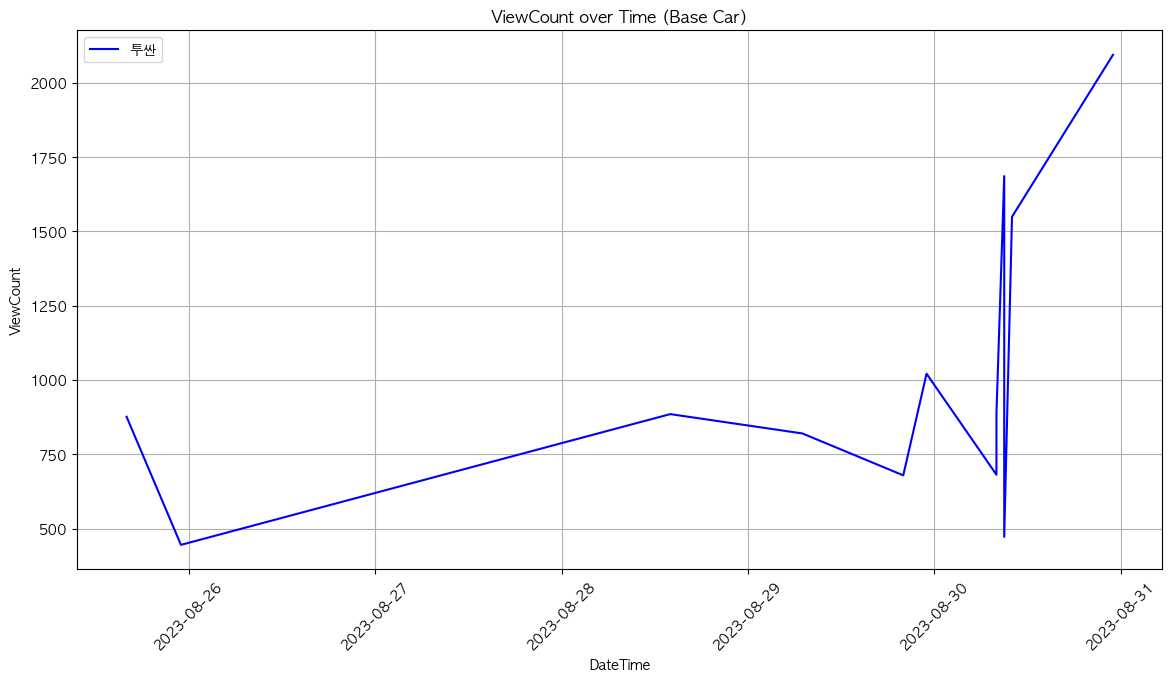

# 2. 정규화하기 전 score 시각화


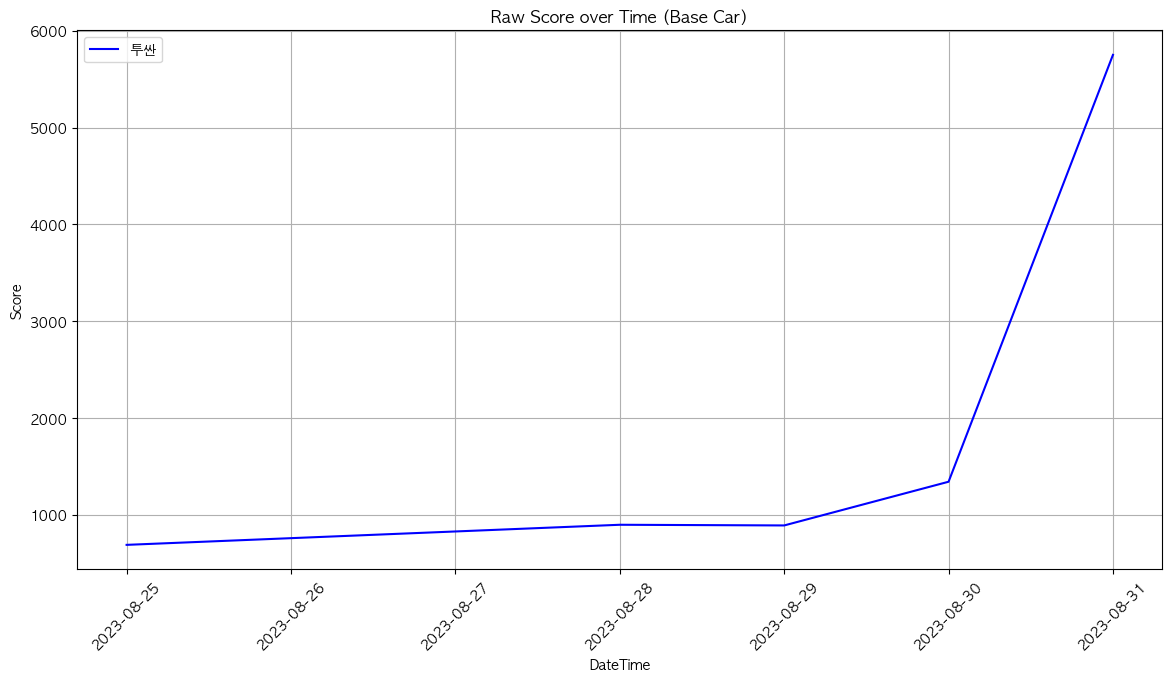

3. 정규화 후 score 시각화


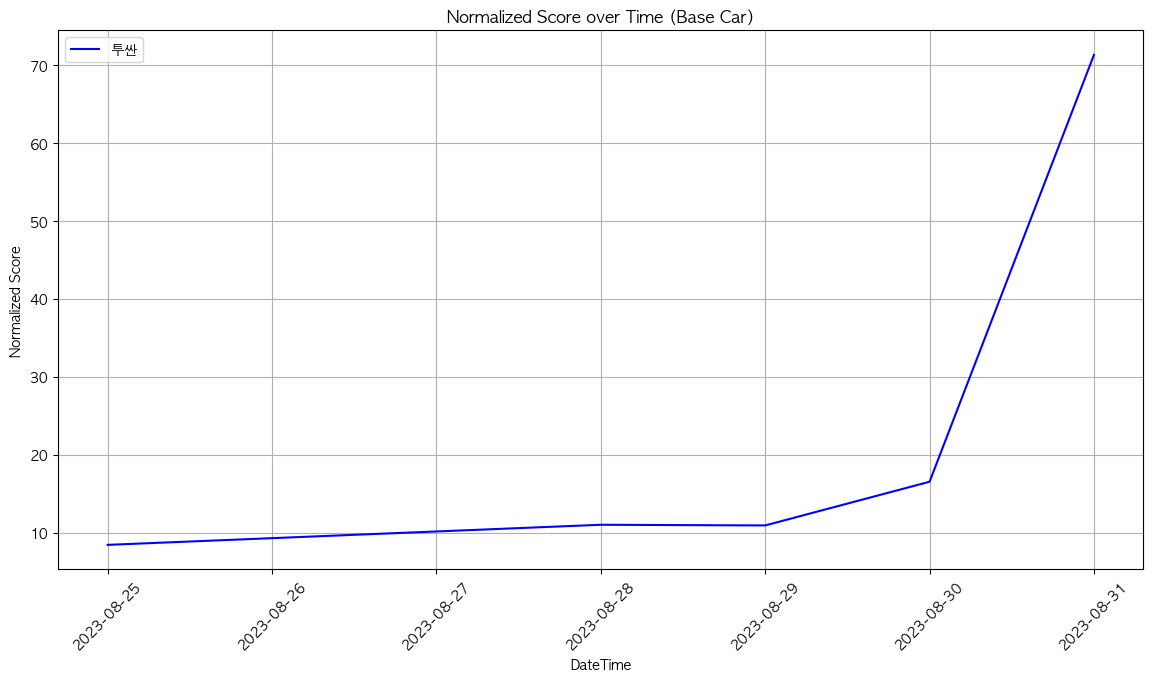

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from matplotlib import font_manager, rc

# 데이터 로드 및 전처리
def load_and_preprocess_data():
    post = pd.read_csv('/Users/admin/softeer/project/0821/전처리/감성분석한post.csv')
    comment = pd.read_csv('/Users/admin/softeer/project/0821/전처리/감성분석한comment.csv')
    issue = pd.read_csv('/Users/admin/softeer/project/0821/전처리/issue_modify.csv')
    word_freq = pd.read_csv('/Users/admin/softeer/project/0821/전처리/word_freq_comment.csv')

    post['ViewCount'] = post['ViewCount'].str.replace(r',', '', regex=True).str.strip().str.split().str[0]
    post['ViewCount'] = pd.to_numeric(post['ViewCount'], errors='coerce')
    post['DateTime'] = pd.to_datetime(post['DateTime'], format='mixed')
    comment['DateTime'] = pd.to_datetime(comment['DateTime'], format='mixed')
    post['DateTime'] = post['DateTime'].dt.floor('h')

    post = post.dropna()
    issue['DateTime'] = pd.to_datetime(issue['DateTime'])

    return post, comment, issue, word_freq

# 24시간 간격으로 그룹화하여 score 계산
def calculate_scores(post, comment):
    score = post.groupby([pd.Grouper(key='DateTime', freq='24h'), 'CarName']).agg({
        'ViewCount': 'sum',
        'CarName': 'size'
    }).rename(columns={'CarName': 'post_count'}).reset_index()

    comment_count = comment.groupby([pd.Grouper(key='DateTime', freq='24h'), 'CarName']).size().reset_index(name='comment_count')
    score = pd.merge(score, comment_count, on=['DateTime', 'CarName'], how='left')
    score['comment_count'] = score['comment_count'].fillna(0)

    score['ViewCount'] = np.where(score['ViewCount'] <= 0, 1, score['ViewCount'])
    score['post_count'] = np.where(score['post_count'] <= 0, 1, score['post_count'])
    score = score[score['DateTime'] >= '2015-01-01']

    # 정규화 전의 score를 시각화하기 위해 추가
    score['score'] = (score['ViewCount'] / score['post_count']) + score['post_count'] * 10 + score['comment_count']
    raw_score = score.copy()  # 정규화하기 전의 score를 복사

    upper_limit = score['score'].quantile(0.95)
    score['score'] = np.where(score['score'] > upper_limit, upper_limit, score['score'])

    min_score = score['score'].min()
    max_score = score['score'].max()
    score['score'] = (score['score'] - min_score) / (max_score - min_score) * 100

    # 시계열 정렬
    score = score.sort_values(by=['CarName', 'DateTime']).reset_index(drop=True)

    return score, raw_score

# 데이터 필터링 및 최종 결과 생성
def filter_and_finalize_results(score, post, sentiment_count, issue, word_freq):
    similarity = score.groupby('CarName').apply(lambda x: x.nlargest(1, 'score')).reset_index(drop=True)

    filtered_score = []
    filtered_post = []
    filtered_sentiment_count = []
    filtered_issues = []
    filtered_word_freq = []

    for _, row in similarity.iterrows():
        similar_car = row['CarName']
        similar_date = row['DateTime']

        start_date = similar_date - timedelta(days=7)
        end_date = similar_date + timedelta(days=7)

        filtered_score.append(score[(score['CarName'] == similar_car) & 
                                    (score['DateTime'] >= start_date) & 
                                    (score['DateTime'] <= end_date)])

        filtered_post_data = post[(post['CarName'] == similar_car) & 
                                  (post['DateTime'] >= start_date) & 
                                  (post['DateTime'] <= end_date)]
        filtered_post_data = filtered_post_data.loc[filtered_post_data.groupby(filtered_post_data['DateTime'].dt.date)['ViewCount'].idxmax()]
        filtered_post.append(filtered_post_data)

        filtered_sentiment_count.append(sentiment_count[(sentiment_count['CarName'] == similar_car) & 
                                                        (sentiment_count['DateTime'] >= start_date) & 
                                                        (sentiment_count['DateTime'] <= end_date)])

        filtered_issues.append(issue[(issue['CarName'] == similar_car) & 
                                     (issue['DateTime'] >= start_date) & 
                                     (issue['DateTime'] <= end_date)])

        filtered_word_freq.append(word_freq[(word_freq['CarName'] == similar_car) & 
                                            (pd.to_datetime(word_freq['Date']) >= start_date) & 
                                            (pd.to_datetime(word_freq['Date']) <= end_date)])

    filtered_score = pd.concat(filtered_score).reset_index(drop=True)
    filtered_post = pd.concat(filtered_post).reset_index(drop=True)
    filtered_sentiment_count = pd.concat(filtered_sentiment_count).reset_index(drop=True)
    filtered_issues = pd.concat(filtered_issues).reset_index(drop=True)
    filtered_word_freq = pd.concat(filtered_word_freq).reset_index(drop=True)

    return filtered_score, filtered_post, filtered_sentiment_count, filtered_issues, filtered_word_freq, similarity

# 시각화 함수들
# 1. 데이터 로드 후 ViewCount 시각화
def plot_viewcount(post_df, base_car, base_date):
    print('# 1. 데이터 로드 후 ViewCount 시각화')
    plt.figure(figsize=(14, 7))
    car_data = post_df[post_df['CarName'] == base_car]
    base_slice = car_data[(car_data['DateTime'] >= base_date - timedelta(days=7)) &
                          (car_data['DateTime'] <= base_date)]
    plt.plot(base_slice['DateTime'], base_slice['ViewCount'], label=base_car, color='blue')
    plt.title('ViewCount over Time (Base Car)')
    plt.xlabel('DateTime')
    plt.ylabel('ViewCount')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. 정규화하기 전 score 시각화
def plot_raw_score(score_df, base_car, base_date):
    print('# 2. 정규화하기 전 score 시각화')
    plt.figure(figsize=(14, 7))
    car_data = score_df[score_df['CarName'] == base_car]
    base_slice = car_data[(car_data['DateTime'] >= base_date - timedelta(days=7)) &
                          (car_data['DateTime'] <= base_date)]
    plt.plot(base_slice['DateTime'], base_slice['score'], label=base_car, color='blue')
    plt.title('Raw Score over Time (Base Car)')
    plt.xlabel('DateTime')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. 정규화 후 score 시각화
def plot_normalized_score(score_df, base_car, base_date):
    print('3. 정규화 후 score 시각화')
    plt.figure(figsize=(14, 7))
    car_data = score_df[score_df['CarName'] == base_car]
    base_slice = car_data[(car_data['DateTime'] >= base_date - timedelta(days=7)) &
                          (car_data['DateTime'] <= base_date)]
    plt.plot(base_slice['DateTime'], base_slice['score'], label=base_car, color='blue')
    plt.title('Normalized Score over Time (Base Car)')
    plt.xlabel('DateTime')
    plt.ylabel('Normalized Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()

# 메인 실행 코드
if __name__ == "__main__":
    post, comment, issue, word_freq = load_and_preprocess_data()
    
    # 1. 데이터 로드 후 ViewCount 시각화
    base_car = '투싼'
    base_date = pd.to_datetime('2023-08-31')
    plot_viewcount(post, base_car, base_date)
    
    # 2. 정규화 하기 전 score 시각화
    score, raw_score = calculate_scores(post, comment)
    plot_raw_score(raw_score, base_car, base_date)
    
    # 3. 정규화 후 score 시각화
    plot_normalized_score(score, base_car, base_date)
    


### 일별 score

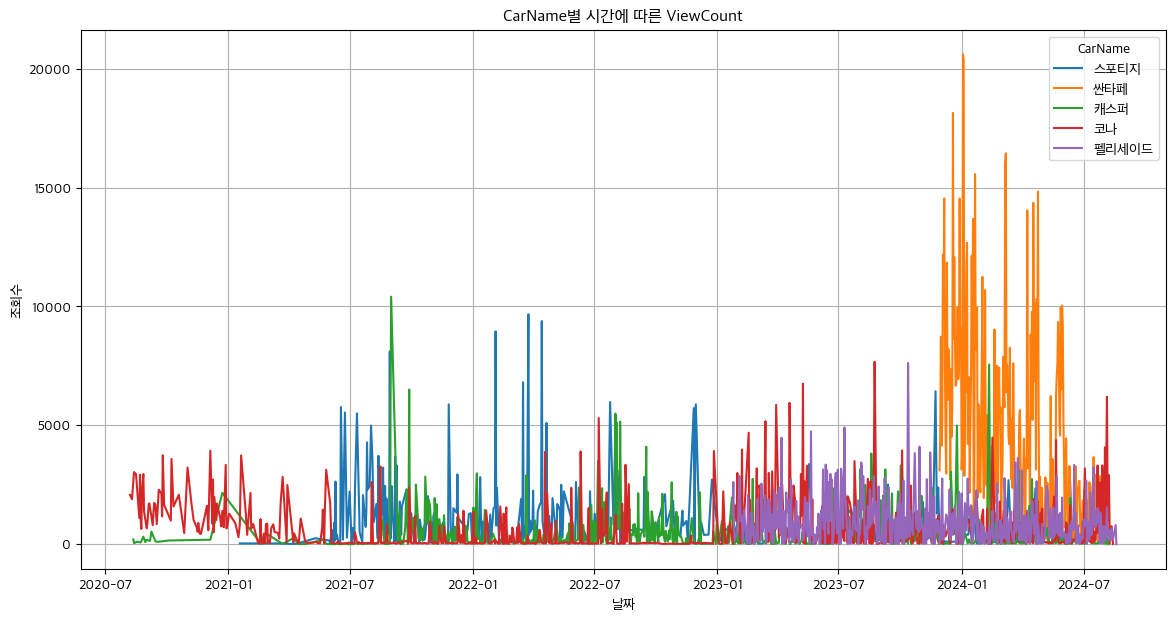

로그 변환 후 평균 score: 0.8080762185313055
클리핑 후 평균 score: 1.4466424224118575


In [11]:
import pandas as pd
import glob
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Mac 환경)
plt.rcParams['font.family'] = 'Apple SD Gothic Neo'

# 데이터 불러오기 및 전처리 함수
def load_and_preprocess_data(post_path, comment_path):
    post_files = glob.glob(os.path.join(post_path, "*.csv"))
    post_df = pd.concat([pd.read_csv(f) for f in post_files], ignore_index=True)
    
    post_df['DateTime'] = pd.to_datetime(post_df['DateTime'], format='mixed')
    post_df['ViewCount'] = post_df['ViewCount'].str.replace(r',', '', regex=True).str.strip().str.split().str[0]
    post_df['ViewCount'] = pd.to_numeric(post_df['ViewCount'], errors='coerce')
    post_df['DateTime'] = post_df['DateTime'].dt.floor('24h')
    post_df = post_df[['URL', 'Title', 'DateTime', 'ViewCount', 'Content', 'CarName']].dropna()
    
    comment_df = pd.read_csv(comment_path)
    comment_df['DateTime'] = pd.to_datetime(comment_df['DateTime'], format='mixed')
    
    return post_df, comment_df

# CarName별로 시간에 따른 ViewCount 시각화 함수
def plot_viewcount_time_series(post_df):
    carname_viewcount = post_df.groupby(['CarName', pd.Grouper(key='DateTime', freq='D')])['ViewCount'].sum().reset_index()

    plt.figure(figsize=(14, 7))
    for car in carname_viewcount['CarName'].unique():
        car_data = carname_viewcount[carname_viewcount['CarName'] == car]
        plt.plot(car_data['DateTime'], car_data['ViewCount'], label=car)

    plt.title('CarName별 시간에 따른 ViewCount')
    plt.xlabel('날짜')
    plt.ylabel('조회수')
    plt.legend(title='CarName')
    plt.grid(True)
    plt.show()

# Score 계산 함수
def calculate_scores(post_df, comment_df):
    # 조회수 정규화 및 Z-Score 계산
    post_df['normalized_viewcount'] = post_df.groupby('CarName')['ViewCount'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    post_df['z_score'] = post_df.groupby('CarName')['ViewCount'].transform(lambda x: (x - x.mean()) / x.std())

    # 정규화된 조회수, 게시물 수, 댓글 수 기반 Score 계산
    score_df = post_df.groupby(['DateTime', 'CarName']).agg({
        'normalized_viewcount': 'sum',
        'CarName': 'size'
    }).rename(columns={'CarName': 'post_count'}).reset_index()

    comment_count_df = comment_df.groupby(['DateTime', 'CarName']).size().reset_index(name='comment_count')
    score_df = pd.merge(score_df, comment_count_df, on=['DateTime', 'CarName'], how='left')
    score_df['comment_count'] = score_df['comment_count'].fillna(0)

    # 가중치를 적용한 최종 Score 계산
    alpha = 1.0  # 조회수 가중치
    beta = 10.0  # 게시물 수 가중치
    gamma = 5.0  # 댓글 수 가중치

    score_df['score'] = (
        score_df['normalized_viewcount'] * alpha +
        score_df['post_count'] / score_df['post_count'].max() * beta +
        score_df['comment_count'] / score_df['comment_count'].max() * gamma
    )

    # 로그 변환
    score_df['log_score'] = np.log1p(score_df['score'])

    # 상위 99% 값을 클리핑
    upper_limit = score_df['score'].quantile(0.99)
    score_df['clipped_score'] = score_df['score'].clip(upper=upper_limit)

    return score_df

# 메인 실행 코드
if __name__ == "__main__":
    post_path = "/Users/admin/softeer/project/0814/post/"
    comment_path = "/Users/admin/softeer/project/0821/전처리/감성분석한comment.csv"
    
    post_df, comment_df = load_and_preprocess_data(post_path, comment_path)
    plot_viewcount_time_series(post_df)
    
    score_df = calculate_scores(post_df, comment_df)
    
    # 로그 변환 후 평균 확인
    mean_log_score = score_df['log_score'].mean()
    print(f"로그 변환 후 평균 score: {mean_log_score}")
    
    # 클리핑 후 평균 확인
    mean_clipped_score = score_df['clipped_score'].mean()
    print(f"클리핑 후 평균 score: {mean_clipped_score}")


### 3시간별 score

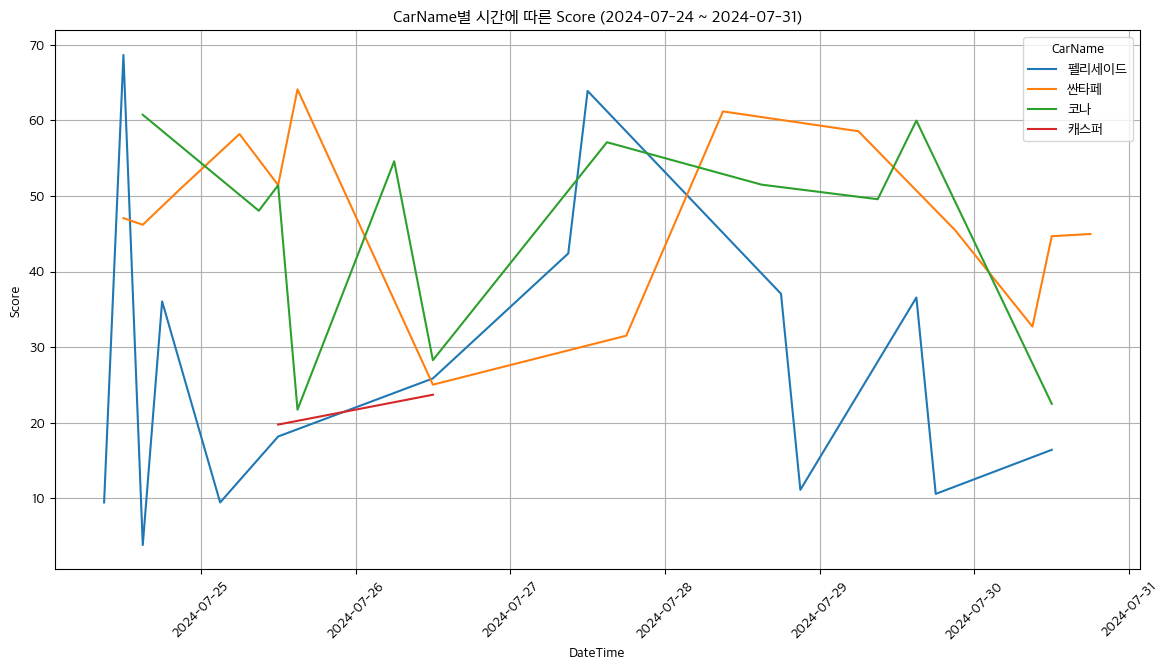

In [119]:
import pandas as pd
import matplotlib.pyplot as plt

# DateTime 열을 시계열 데이터로 변환
score_df['DateTime'] = pd.to_datetime(score_df['DateTime'])

# 2024-07-24부터 2024-07-31까지의 데이터만 필터링
start_date = '2024-07-24'
end_date = '2024-07-31'
filtered_score_df = score_df[(score_df['DateTime'] >= start_date) & (score_df['DateTime'] <= end_date)]

# 특정 CarName으로 필터링 ('투싼' 예시)
plt.figure(figsize=(14, 7))

for car in filtered_score_df['CarName'].unique():
    car_data = filtered_score_df[filtered_score_df['CarName'] == car]
    plt.plot(car_data['DateTime'], car_data['log_score'], label=car)

plt.title('CarName별 시간에 따른 Score (2024-07-24 ~ 2024-07-31)')
plt.xlabel('DateTime')
plt.ylabel('Score')
plt.xticks(rotation=45)  # X축 라벨을 45도 회전하여 가독성 증가
plt.legend(title='CarName')
plt.grid(True)
plt.show()


### 시간별 score

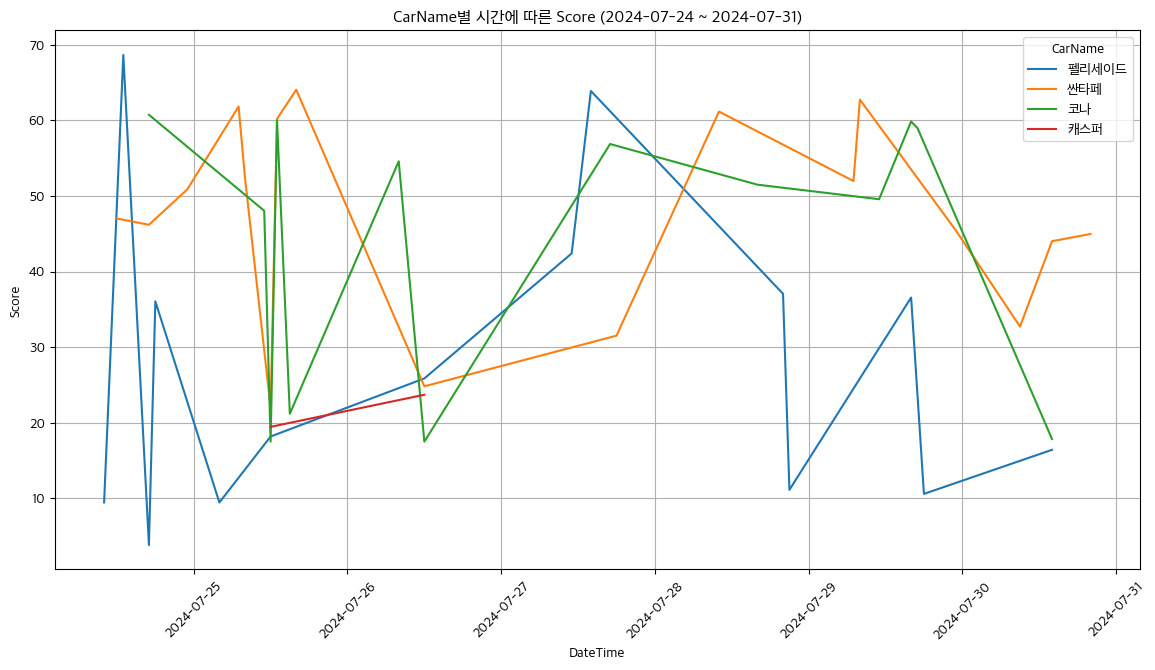

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# DateTime 열을 시계열 데이터로 변환
score_df['DateTime'] = pd.to_datetime(score_df['DateTime'])

# 2024-07-24부터 2024-07-31까지의 데이터만 필터링
start_date = '2024-07-24'
end_date = '2024-07-31'
filtered_score_df = score_df[(score_df['DateTime'] >= start_date) & (score_df['DateTime'] <= end_date)]

# 특정 CarName으로 필터링 ('투싼' 예시)
plt.figure(figsize=(14, 7))

for car in filtered_score_df['CarName'].unique():
    car_data = filtered_score_df[filtered_score_df['CarName'] == car]
    plt.plot(car_data['DateTime'], car_data['log_score'], label=car)

plt.title('CarName별 시간에 따른 Score (2024-07-24 ~ 2024-07-31)')
plt.xlabel('DateTime')
plt.ylabel('Score')
plt.xticks(rotation=45)  # X축 라벨을 45도 회전하여 가독성 증가
plt.legend(title='CarName')
plt.grid(True)
plt.show()


### 30분 간격 score

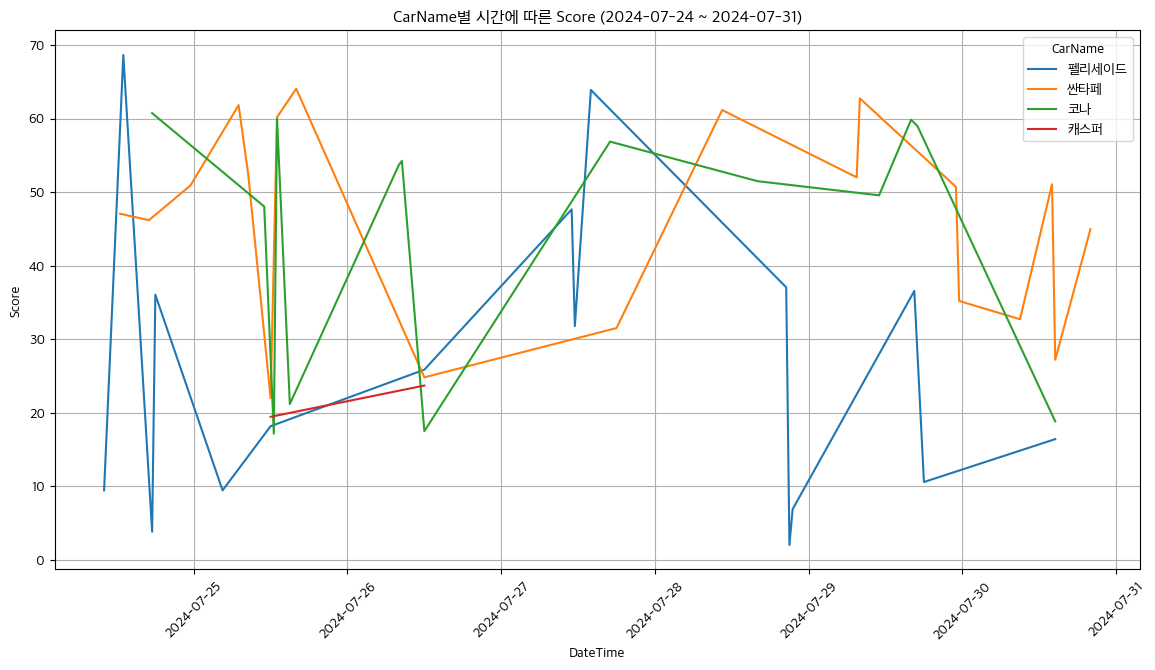

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# DateTime 열을 시계열 데이터로 변환
score_df['DateTime'] = pd.to_datetime(score_df['DateTime'])

# 2024-07-24부터 2024-07-31까지의 데이터만 필터링
start_date = '2024-07-24'
end_date = '2024-07-31'
filtered_score_df = score_df[(score_df['DateTime'] >= start_date) & (score_df['DateTime'] <= end_date)]

# 특정 CarName으로 필터링 ('투싼' 예시)
plt.figure(figsize=(14, 7))

for car in filtered_score_df['CarName'].unique():
    car_data = filtered_score_df[filtered_score_df['CarName'] == car]
    plt.plot(car_data['DateTime'], car_data['log_score'], label=car)

plt.title('CarName별 시간에 따른 Score (2024-07-24 ~ 2024-07-31)')
plt.xlabel('DateTime')
plt.ylabel('Score')
plt.xticks(rotation=45)  # X축 라벨을 45도 회전하여 가독성 증가
plt.legend(title='CarName')
plt.grid(True)
plt.show()
